### **Reverse Search + Recommendation CIFAR 10 - VGG19**

In this example we use th latest layer of an Imagenet architecture as a feature-embedding layer. <br>
Later we use cosine similarity to find the most similar images from imagenet <br>
We use the train data to calculate the embeddings and choose randomly from the test data photos to find the similar ones on the train data<br>

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from annoy import AnnoyIndex
import time

import sys
sys.stderr = open('err.txt', 'w')

2025-02-25 08:34:32.391394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 08:34:32.484213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 08:34:32.533333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 08:34:32.546849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 08:34:32.605658: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:22:00.0, compute capability: 8.6


In [3]:
# Load a pre-trained VGG19
VGG19_model = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_shape=(32, 32, 3)
)
model = tf.keras.Sequential([
    VGG19_model,
    tf.keras.layers.GlobalAveragePooling2D(),
])

In [4]:
# Define a function to preprocess an image and extract features
def extract_features(img):
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img, verbose=0)
    # Apply L2 normalization to the features
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    return features

# Define a directory containing the database of images to search through
database_directory = "./data/reverse-search/"

In [5]:
# Load CIFAR
label_dict = {0: "airplane",
                     1: "automobile",
                     2: "bird",
                     3: "cat",
                     4: "deer",
                     5: "dog",
                     6: "frog",
                     7: "horse",
                     8: "ship",
                     9: "truck"}

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, x_test.shape)

In [6]:
database_features = []
database_filenames = []

start_time = time.time()

for i, image in enumerate(x_train):
    features = extract_features(image)
    database_features.append(features.flatten())  # Flatten the features
    
end_time = time.time()
print(f"Feature extraction completed in {(end_time - start_time)/60:.2f} minutes")

Feature extraction completed in 50.55 minutes


In [7]:
# Create an AnnoyIndex for approximate nearest neighbor search
num_trees = 1500  # Adjust this parameter for better accuracy
feature_dim = len(database_features[0])
annoy_index = AnnoyIndex(feature_dim, 'angular')              # Use cosine similarity

# Add database features to the AnnoyIndex
for i, feature in enumerate(database_features):
    annoy_index.add_item(i, feature)

# Build the index
annoy_index.build(num_trees)

True

In [13]:
# Select randomly n unique images
num_images = 10
indices = np.random.choice(x_test.shape[0], num_images, replace=False)
selected_images = x_test[indices]

In [14]:
top_n = 10 # Number of similar images careful you must change visualization then

In [15]:
similar_images = []
for i, image_test in enumerate(selected_images):
    query_features = extract_features(image_test).flatten()
    similar_indices = annoy_index.get_nns_by_vector(query_features, top_n)
    similar_images.append(similar_indices)
    


<Figure size 640x480 with 0 Axes>

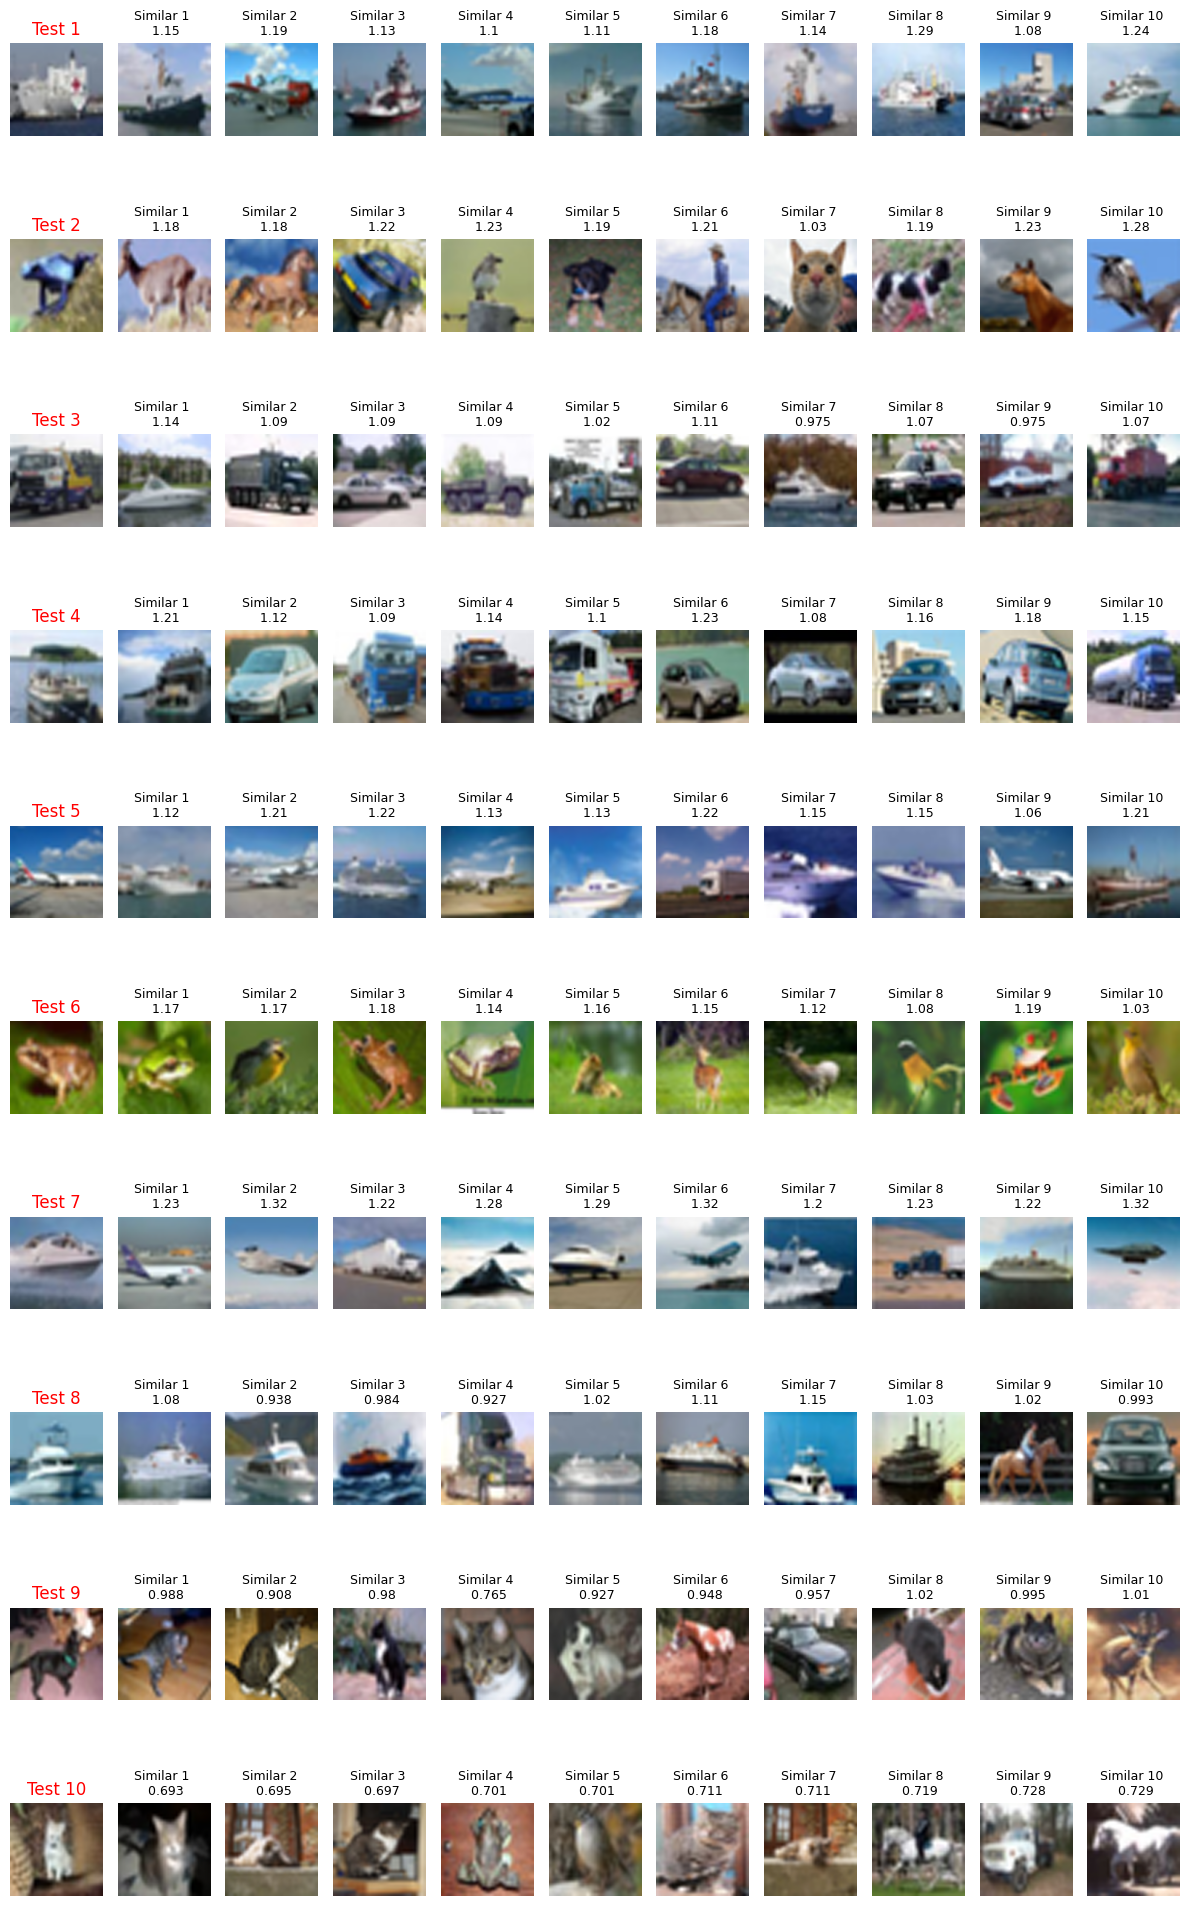

In [20]:
fig = plt.gcf()

fig, axes = plt.subplots(num_images, 11, figsize=(12,20))

for i in range(10):  # For each test image
    # Plot the test image
    image_test = cv2.resize(selected_images[i], (128, 128), interpolation=cv2.INTER_CUBIC)
    axes[i, 0].imshow(image_test)
    axes[i, 0].set_title(f"Test {i+1}", color='red')
    axes[i, 0].axis('off')  # Remove axis for cleaner look

    # Plot the 5 most similar images
    k = similar_images[i]
    for j in range(10):
        distance = np.linalg.norm(query_features - database_features[k[j]])
        image_sim = cv2.resize(x_train[k[j]], (128, 128), interpolation=cv2.INTER_CUBIC)
        axes[i, j + 1].imshow(image_sim)
        axes[i, j + 1].set_title(f"Similar {j+1} \n {distance:.3}",fontsize=9, loc='center')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()